# custom seaborn plots for scRNA-seq

## Background

- scanpy has inflexible plotting syntax for clusters
- can't easily order or create new colormaps 
- jitterplots in scanpy are really ugly

## Methods

- KDE
- summary statistics 

## Findings

- can easily make custom seaborn with nice manipulations and removing white space between subplots
- can also add ax1=ax.twin() to put axis on the opposite side
- distributions make for much better visualizations of distributional differences than jitter plots

## Future directions

- TODO (before re-making scanpy volcano plots): try re-making them with fewer labels, between SCA1 and WT with `wspace,hspace=0`

In [1]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text
import warnings



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")


In [2]:

# fps
dfp = '/home/ngr4/project/scnd/data/'
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'
sc.settings.figdir = pfp

def loader(fname,fpath,backed=None) : 
    start = time.time()
    adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    Anndata.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))
    

if True :
    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = loader(fname,pdfp)
    
if True :
    # load mouse
    fname='mouse_MT_bbknn.h5ad'
    %memit mdata = loader(fname,pdfp)


loaded @200330.22:49:42
took 46.97-s to load data
peak memory: 20557.71 MiB, increment: 20353.70 MiB
loaded @200330.22:52:41
took 178.21-s to load data
peak memory: 159628.08 MiB, increment: 149211.61 MiB


In [3]:
def AnnData2df(AnnData,genes,layer='imputed_bbknn',id1='timepoint',id1_val='5wk',id2='ctype',id2_val='Purkinje cell',add_obs='genotype',scaler='range'):
    """Quick grab, select layer.
    
    Args:
      AnnData (object): 
      id1 (string): where in AnnData.obs to pull
      genes (list): list of genes to subset
      scaler (str): if 'range', min-max scaled to 0 and 1 
      
    Returns:
      pd.DataFrame
    """
    if id2 is not None :
        adata = sc.AnnData(AnnData[(AnnData.obs[id1]==id1_val) & (AnnData.obs[id2]==id2_val),:])
        adata = sc.AnnData(adata[:,genes])
    elif id1 is not None :
        adata = sc.AnnData(AnnData[(AnnData.obs[id1]==id1_val),:])
        adata = sc.AnnData(adata[:,genes])
    else : # both id1/id2 not given
        adata = sc.AnnData(adata[:,genes])

    if layer is not None:
        x = adata.layers[layer]
    else:
        x = adata.X
                
    if scaler is not None :
        x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    X = pd.DataFrame(x,columns=adata.var_names,index=adata.obs.index)
        
    if add_obs is not None :
        X[add_obs]=adata.obs[add_obs]
        
    return X

In [4]:
# genes of interest
genes = {'Human OL':['DPYD', 'PPP2R2B', 'MBP', 'MOBP', 'NTM', 'S100B', 
                      'FGFR2', 'HAPLN2', 'PRKCA', 'MOG', 'ZEB2', 'PLP1', 
                      'ENPP6', 'MAG', 'CNP', 'CADM2', 'ERBB4', 'PLXDC2', 
                      'KCNIP4', 'NLGN1', 'NCAM2', 'HSPA1A', 'ZNF385D', 
                      'ANK3', 'FGF14', 'QDPR', 'CDH18', 'FCHSD2', 'LAMA2', 
                      'CCP110'],
                 'Mouse PC':['Grid2', 'Anks1b', 'Etl4', 'Fam107b', 
                       'Itpr1', 'Garnl3', 'Rgs8', 'Auts2', 'Col18a1', 
                       'Kcnip4', 'Car8', 'Kcnab1', 'Grid2ip', 'Cacna1a', 
                       'Kcnma1', 'Meg3', 'Pcdh9', 'Tenm2', 'Lsamp', 'Cntn5', 
                       'Lrp1b', 'Nlgn1', 'Lrrc4c', 'Xkr4', 'Sgcz', 'Pde1c', 
                       'Cntnap2', 'Nrxn3', 'Nrxn1', 'Asic2'],
                 'Mouse OL':['Dpyd','Ppp2r2b','Mbp','Mobp','Ntm','S100b','Fgfr2',
                             'Hapln2','Prkca','Mog','Zeb2','Plp1','Enpp6','Mag',
                             'Cnp','Cadm2','Erbb4','Plxdc2','Kcnip4','Nlgn1',
                             'Ncam2','Hspa1a','Ank3','Fgf14','Qdpr',
                             'Cdh18','Fchsd2','Lama2','Ccp110']}

# aesthetics 
cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}

## Distribution comparison


starting timepoint 5wk


starting timepoint 12wk


starting timepoint 18wk


starting timepoint 24wk


starting timepoint 30wk


starting timepoint 5wk


starting timepoint 12wk


starting timepoint 18wk


starting timepoint 24wk


starting timepoint 30wk



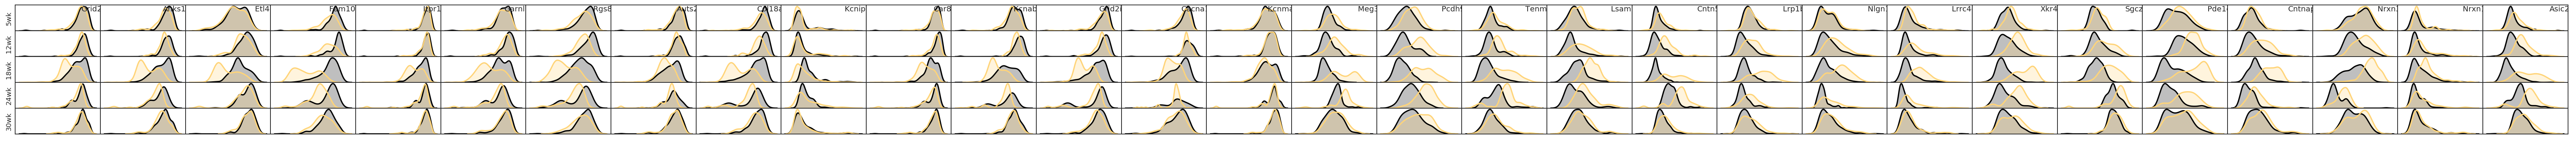

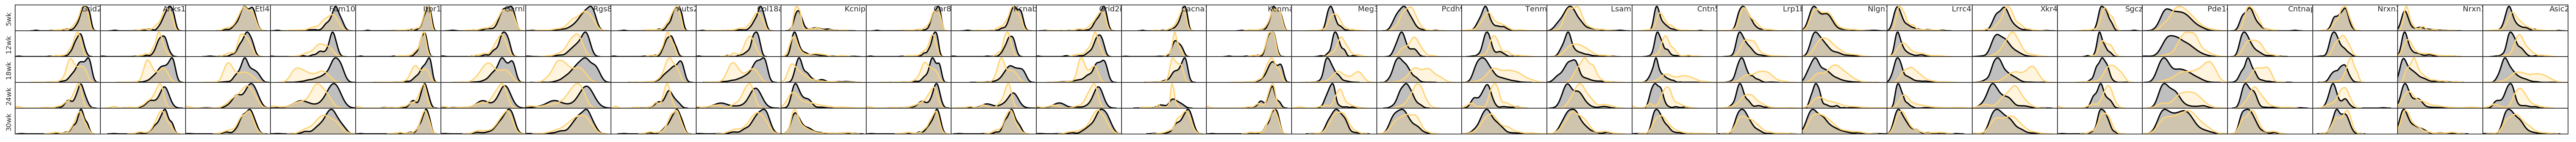

In [5]:
# mosue PC normed & unnormed (in line)
gene_list_id = 'Mouse PC'
cluster='ctype'
ctype='Purkinje cell'

df = pd.DataFrame()
for t in mdata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
    
    ## subset data
    X = AnnData2df(mdata,genes[gene_list_id],layer='imputed_bbknn',
                   id1='timepoint',id1_val=t,id2=cluster,id2_val=ctype,
                   add_obs='genotype',scaler='range')
    X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
    X['Timepoint'] = [t]*X.shape[0]

    ## add back data
    df = df.append(X, ignore_index=True)
    del X

ncol = genes[gene_list_id].__len__()
fig,axarr = plt.subplots(5,ncol,figsize=(2*ncol,3))

for j,g in enumerate(genes[gene_list_id]):
    for i,t in enumerate(['5wk','12wk','18wk','24wk','30wk']) : 
        ax = axarr[i,j]
        p1 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='WT') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['WT'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        p2 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='SCA1') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['SCA1'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        ax1 = ax.twinx()
        ax1.set_yticks([0.,1.])
    #     ax1.set_ylabel(g)
        if j==0:
            ax.set_ylabel(t)
        else:
            ax.set_ylabel('')
        ax.set_yticks([])
        ax1.set_yticks([])
#         if t=='30wk':
#             ax.set_xticks([0,0.25,0.50,0.75,1])
#         else:
#             ax.set_xticks([])
        ax.set_xticks([])
        if t=='5wk':
            x = np.min(p1.get_xbound()+p2.get_xbound())
            y = np.max(p1.get_ybound()+p2.get_ybound())
            ax.text(0.9,0.85,g,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = ax.transAxes)
    #     if t=='30wk':
    #         ax1.set_yticks([0.])
    #     elif t=='5wk':
    #         ax1.set_yticks([1.])
    #     else:
    #         ax1.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'dist_{}.pdf'.format(gene_list_id,t)),dpi=300, bbox_inches='tight')
    
# try without normalization
df = pd.DataFrame()
for t in mdata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
        
    ## subset data
    X = AnnData2df(mdata,genes[gene_list_id],layer='imputed_bbknn',
                   id1='timepoint',id1_val=t,id2=cluster,id2_val=ctype,
                   add_obs='genotype',scaler=None)
    X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
    X['Timepoint'] = [t]*X.shape[0]

    ## add back data
    df = df.append(X, ignore_index=True)
    del X

ncol = genes[gene_list_id].__len__()
fig,axarr = plt.subplots(5,ncol,figsize=(2*ncol,3))

for j,g in enumerate(genes[gene_list_id]):
    for i,t in enumerate(['5wk','12wk','18wk','24wk','30wk']) : 
        ax = axarr[i,j]
        # per timepoint, get min max for comparison
        x_max = df.loc[df['Gene']==g,'Expression'].max()+0.1*df.loc[df['Gene']==g,'Expression'].max() # 1% padding
        x_min = df.loc[df['Gene']==g,'Expression'].min()-0.1*df.loc[df['Gene']==g,'Expression'].min() # 1% padding
        p1 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='WT') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['WT'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        p2 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='SCA1') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['SCA1'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        ax1 = ax.twinx()
        ax1.set_yticks([0.,1.])
    #     ax1.set_ylabel(g)
        if j==0:
            ax.set_ylabel(t)
        else:
            ax.set_ylabel('')
        ax.set_yticks([])
        if True :
            # highlight differences across time
            ax1.set_yticks([]) 
#         if t=='30wk':
#             ax.set_xticks([0,0.25,0.50,0.75,1])
#         else:
#             ax.set_xticks([])
        ax.set_xticks([])
        ax.set_xlim([x_min,x_max])
        if t=='5wk':
            x = np.min(p1.get_xbound()+p2.get_xbound())
            y = np.max(p1.get_ybound()+p2.get_ybound())
            ax.text(0.9,0.85,g,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = ax.transAxes)
    #     if t=='30wk':
    #         ax1.set_yticks([0.])
    #     elif t=='5wk':
    #         ax1.set_yticks([1.])
    #     else:
    #         ax1.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'dist_{}_NotNormed.pdf'.format(gene_list_id,t)),dpi=300, bbox_inches='tight')


starting timepoint 5wk


starting timepoint 12wk


starting timepoint 18wk


starting timepoint 24wk


starting timepoint 30wk


starting timepoint 5wk


starting timepoint 12wk


starting timepoint 18wk


starting timepoint 24wk


starting timepoint 30wk



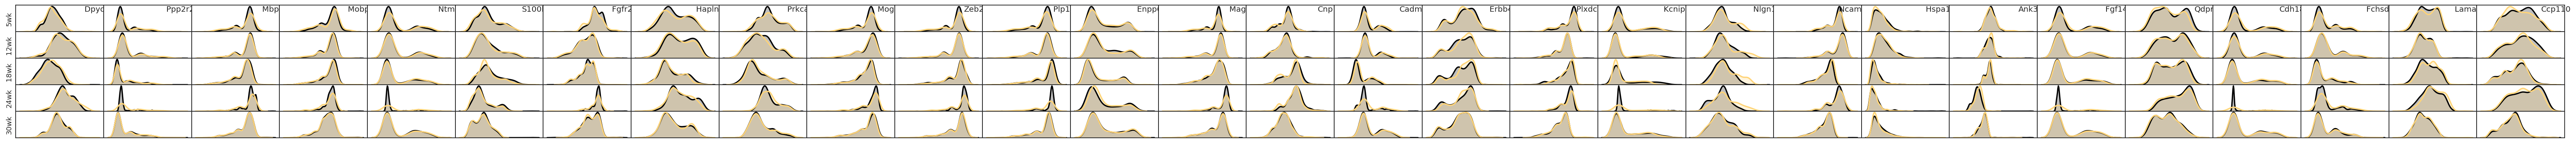

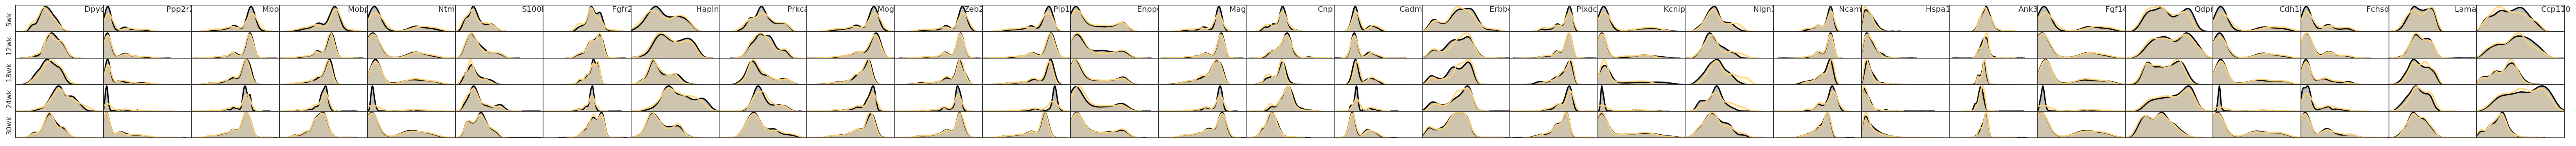

In [6]:
# mosue
gene_list_id = 'Mouse OL'
cluster='ctype'
ctype='Oligodendrocyte'

df = pd.DataFrame()
for t in mdata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
    
    ## subset data
    X = AnnData2df(mdata,genes[gene_list_id],layer='imputed_bbknn',
                   id1='timepoint',id1_val=t,id2=cluster,id2_val=ctype,
                   add_obs='genotype',scaler='range')
    X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
    X['Timepoint'] = [t]*X.shape[0]

    ## add back data
    df = df.append(X, ignore_index=True)
    del X

ncol = genes[gene_list_id].__len__()
fig,axarr = plt.subplots(5,ncol,figsize=(2*ncol,3))

for j,g in enumerate(genes[gene_list_id]):
    for i,t in enumerate(['5wk','12wk','18wk','24wk','30wk']) : 
        ax = axarr[i,j]
        p1 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='WT') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['WT'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        p2 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='SCA1') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['SCA1'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        ax1 = ax.twinx()
        ax1.set_yticks([0.,1.])
    #     ax1.set_ylabel(g)
        if j==0:
            ax.set_ylabel(t)
        else:
            ax.set_ylabel('')
        ax.set_yticks([])
        ax1.set_yticks([])
#         if t=='30wk':
#             ax.set_xticks([0,0.25,0.50,0.75,1])
#         else:
#             ax.set_xticks([])
        ax.set_xticks([])
        if t=='5wk':
            x = np.min(p1.get_xbound()+p2.get_xbound())
            y = np.max(p1.get_ybound()+p2.get_ybound())
            ax.text(0.9,0.85,g,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = ax.transAxes)
    #     if t=='30wk':
    #         ax1.set_yticks([0.])
    #     elif t=='5wk':
    #         ax1.set_yticks([1.])
    #     else:
    #         ax1.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'dist_{}.pdf'.format(gene_list_id,t)),dpi=300, bbox_inches='tight')
    
# try without normalization
df = pd.DataFrame()
for t in mdata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
        
    ## subset data
    X = AnnData2df(mdata,genes[gene_list_id],layer='imputed_bbknn',
                   id1='timepoint',id1_val=t,id2=cluster,id2_val=ctype,
                   add_obs='genotype',scaler=None)
    X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
    X['Timepoint'] = [t]*X.shape[0]

    ## add back data
    df = df.append(X, ignore_index=True)
    del X

ncol = genes[gene_list_id].__len__()
fig,axarr = plt.subplots(5,ncol,figsize=(2*ncol,3))

for j,g in enumerate(genes[gene_list_id]):
    for i,t in enumerate(['5wk','12wk','18wk','24wk','30wk']) : 
        ax = axarr[i,j]
        # per timepoint, get min max for comparison
        x_max = df.loc[df['Gene']==g,'Expression'].max()+0.1*df.loc[df['Gene']==g,'Expression'].max() # 1% padding
        x_min = df.loc[df['Gene']==g,'Expression'].min()-0.1*df.loc[df['Gene']==g,'Expression'].min() # 1% padding
        p1 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='WT') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['WT'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        p2 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='SCA1') & (df['Timepoint']==t)),'Expression'], 
                    shade=True, color=cmap_genotype['SCA1'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                         legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
        ax1 = ax.twinx()
        ax1.set_yticks([0.,1.])
    #     ax1.set_ylabel(g)
        if j==0:
            ax.set_ylabel(t)
        else:
            ax.set_ylabel('')
        ax.set_yticks([])
        if True :
            # highlight differences across time
            ax1.set_yticks([]) 
#         if t=='30wk':
#             ax.set_xticks([0,0.25,0.50,0.75,1])
#         else:
#             ax.set_xticks([])
        ax.set_xticks([])
        ax.set_xlim([x_min,x_max])
        if t=='5wk':
            x = np.min(p1.get_xbound()+p2.get_xbound())
            y = np.max(p1.get_ybound()+p2.get_ybound())
            ax.text(0.9,0.85,g,
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = ax.transAxes)
    #     if t=='30wk':
    #         ax1.set_yticks([0.])
    #     elif t=='5wk':
    #         ax1.set_yticks([1.])
    #     else:
    #         ax1.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'dist_{}_NotNormed.pdf'.format(gene_list_id,t)),dpi=300, bbox_inches='tight')

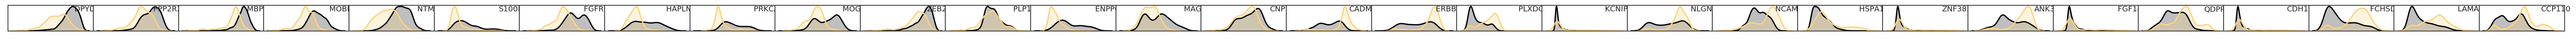

In [ ]:
# human
gene_list_id = 'Human OL'
cluster='ctype'
ctype='Oligodendrocyte'

if True : # not encoded yet
        hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]
        
df = pd.DataFrame()
    
## subset data
X = AnnData2df(hdata,genes[gene_list_id],layer='imputed_bbknn',
               id1=cluster,id1_val=ctype,id2=None,
               add_obs='genotype',scaler='range')
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
X['Timepoint'] = [t]*X.shape[0]

## add back data
df = df.append(X, ignore_index=True)
del X

ncol = genes[gene_list_id].__len__()
fig,axarr = plt.subplots(1,ncol,figsize=(2*ncol,3/5))

for j,g in enumerate(genes[gene_list_id]):
    ax = axarr[j]
    p1 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='WT')),'Expression'], 
                shade=True, color=cmap_genotype['WT'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                     legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
    p2 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='SCA1')),'Expression'], 
                shade=True, color=cmap_genotype['SCA1'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                     legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
    ax1 = ax.twinx()
    ax1.set_yticks([0.,1.])
#     ax1.set_ylabel(g)
    ax.set_ylabel('')
    ax.set_yticks([])
    ax1.set_yticks([])
#         if t=='30wk':
#             ax.set_xticks([0,0.25,0.50,0.75,1])
#         else:
#             ax.set_xticks([])
    ax.set_xticks([])
    x = np.min(p1.get_xbound()+p2.get_xbound())
    y = np.max(p1.get_ybound()+p2.get_ybound())
    ax.text(0.9,0.85,g,
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
#     if t=='30wk':
#         ax1.set_yticks([0.])
#     elif t=='5wk':
#         ax1.set_yticks([1.])
#     else:
#         ax1.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'dist_{}.pdf'.format(gene_list_id,t)),dpi=300, bbox_inches='tight')
    
# try without normalization
df = pd.DataFrame()

## subset data
X = AnnData2df(hdata,genes[gene_list_id],layer='imputed_bbknn',
               id1=cluster,id1_val=ctype,id2=None,
               add_obs='genotype',scaler=None)
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
X['Timepoint'] = [t]*X.shape[0]

## add back data
df = df.append(X, ignore_index=True)
del X

ncol = genes[gene_list_id].__len__()
fig,axarr = plt.subplots(1,ncol,figsize=(2*ncol,3/5))

for j,g in enumerate(genes[gene_list_id]):
    ax = axarr[j]
    # per timepoint, get min max for comparison
    x_max = df.loc[df['Gene']==g,'Expression'].max()+0.1*df.loc[df['Gene']==g,'Expression'].max() # 1% padding
    x_min = df.loc[df['Gene']==g,'Expression'].min()-0.1*df.loc[df['Gene']==g,'Expression'].min() # 1% padding
    p1 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='WT')),'Expression'], 
                shade=True, color=cmap_genotype['WT'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                     legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
    p2 = sns.kdeplot(data=df.loc[((df['Gene']==g) & (df['genotype']=='SCA1')),'Expression'], 
                shade=True, color=cmap_genotype['SCA1'], kernel='gau', bw='scott', gridsize=100, cut=3, clip=None, 
                     legend=False, cumulative=False, shade_lowest=True, cbar=False, cbar_ax=None, cbar_kws=None, ax=ax,lw=1.7)
    ax1 = ax.twinx()
    ax1.set_yticks([0.,1.])
#     ax1.set_ylabel(g)
    ax.set_ylabel('')
    ax.set_yticks([])
    if True :
        # highlight differences across time
        ax1.set_yticks([]) 
#         if t=='30wk':
#             ax.set_xticks([0,0.25,0.50,0.75,1])
#         else:
#             ax.set_xticks([])
    ax.set_xticks([])
    ax.set_xlim([x_min,x_max])
    x = np.min(p1.get_xbound()+p2.get_xbound())
    y = np.max(p1.get_ybound()+p2.get_ybound())
    ax.text(0.9,0.85,g,
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
#     if t=='30wk':
#         ax1.set_yticks([0.])
#     elif t=='5wk':
#         ax1.set_yticks([1.])
#     else:
#         ax1.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'dist_{}_NotNormed.pdf'.format(gene_list_id,t)),dpi=300, bbox_inches='tight')

## Jitter plots

In [9]:
# human
gene_list_id = 'Human OL'
cluster='ctype'
ctype='Oligodendrocyte'

if True : # not encoded yet
        hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]
        
df = pd.DataFrame()
    
## subset data
X = AnnData2df(hdata,genes[gene_list_id],layer='imputed_bbknn',
               id1=cluster,id1_val=ctype,id2=None,
               add_obs='genotype',scaler='range')
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
X['Timepoint'] = [t]*X.shape[0]

## add back data
df = df.append(X, ignore_index=True)
del X

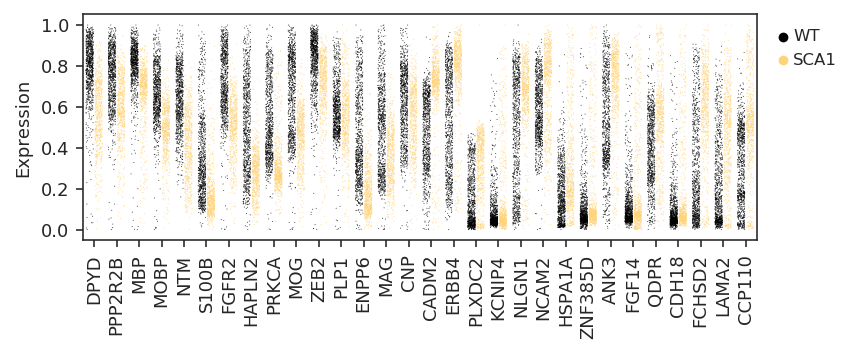

In [33]:
fig,ax=plt.subplots(1,1,figsize=(6,2))
p1 = sns.stripplot(x='Gene', y='Expression', hue='genotype', data=df, order=None, hue_order=['WT','SCA1'], jitter=0.33, dodge=True, 
                  orient=None, color=None, palette=cmap_genotype, size=0.5, alpha=0.8, edgecolor='gray', linewidth=0,ax=ax,
                  rasterized=True)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.legend().set_title('')
ax.legend(bbox_to_anchor=(1.01,1))
if True :
    # save plot
    fig.savefig(os.path.join(pfp,'jitter_{}.pdf'.format(gene_list_id,t)),dpi=300, bbox_inches='tight')

In [34]:
genes_subgroups={
    'humOL1':[
        'MBP',
        'MOBP',
        'HAPLN2',
        'MOG',
        'PLP1',
        'MAG',
        'CNP',],
    'humOL2':[
        'DPYD',
        'PPP2R2B',
        'NTM',
        'S100B',
        'FGFR2',
        'PRKCA',
        'ZEB2',
        'ENPP6',],
    'humOL3':[
        'CADM2',
        'ERBB4',
        'PLXDC2',
        'NLGN1',
        'NCAM2',
        'ANK3',
        'QDPR',
        'FCHSD2',
        'LAMA2',
        'CCP110',]}

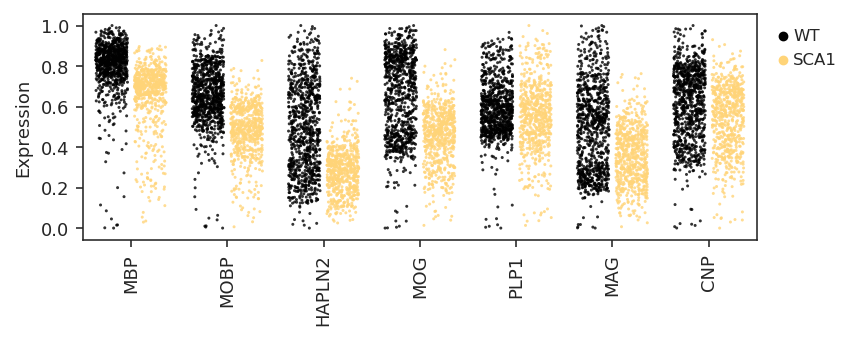

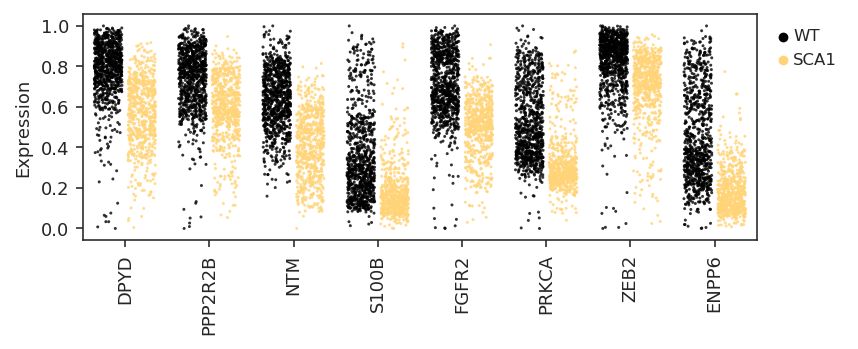

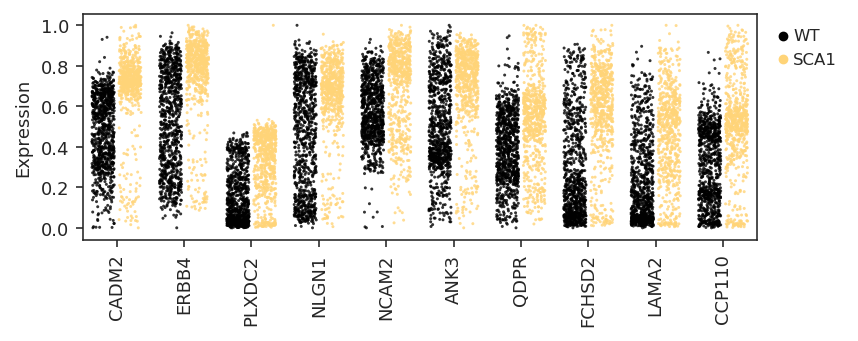

In [37]:
for k in genes_subgroups.keys():
    df_subset = df.loc[df['Gene'].isin(genes_subgroups[k]),:]
    
    fig,ax=plt.subplots(1,1,figsize=(6,2))
    p1 = sns.stripplot(x='Gene', y='Expression', hue='genotype', data=df_subset, order=None, hue_order=['WT','SCA1'], jitter=0.33, dodge=True, 
                      orient=None, color=None, palette=cmap_genotype, size=0.5, alpha=0.8, edgecolor='gray', linewidth=0,ax=ax,
                      rasterized=True, s=1.5)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.legend().set_title('')
    ax.legend(bbox_to_anchor=(1.01,1))
    if True :
        # save plot
        fig.savefig(os.path.join(pfp,'jitter_{}.pdf'.format(k)),dpi=300, bbox_inches='tight')

In [44]:
genes_OL={
    'humOL1':[
        'MBP',
        'MOBP',
        'HAPLN2',
        'MOG',
        'PLP1',
        'MAG',
        'CNP',
        'TF',
        'ENPP6',
        'KLK6',],
    'humOL2':[
        'CADM2',
        'ERBB4',
        'PLXDC2',
        'NLGN1',
        'NCAM2',
        'ANK3',
        'QDPR',
        'FCHSD2',
        'LAMA2',
        'CCP110',],
    'humOL5':[
        'ASCL1',
        'HES1',
        'ID2',
        'ID4',
        'MYT1',
        'NKX2-2',
        'OLIG1',
        'OLIG2',
        'TCF7L2',
        'SOX9',
        'SOX10',
        'NKX6-2',
        'SOX17',
        'ZNF24',
        'ZNF488',
        'ZNF536',
        'MYRF',]}

genes_OPC={
    'humOPC3':[
        'DSCAM',
        'OPHN1',
        'EPN2',
        'SLC35F1',
        'RBFOX1',
        'SMOC1',
        'SUMF1',
        'TNR',
        'CNTNAP2',
        'MGLL',],
    'humOPC4':[
        'PCDH9',
        'LHFPL3',
        'NEAT1',
        'KCND2',
        'LRP1B',
        'ADGRB3',
        'FGF14',
        'SLC24A2',
        'NCAM2',
        'ZBTB20',],
    'humOPC5':[
        'ASCL1',
        'HES1',
        'ID2',
        'ID4',
        'MYT1',
        'NKX2-2',
        'OLIG1',
        'OLIG2',
        'TCF7L2',
        'SOX9',
        'SOX10',
        'NKX6-2',
        'SOX17',
        'ZNF24',
        'ZNF488',
        'ZNF536',
        'MYRF',]}

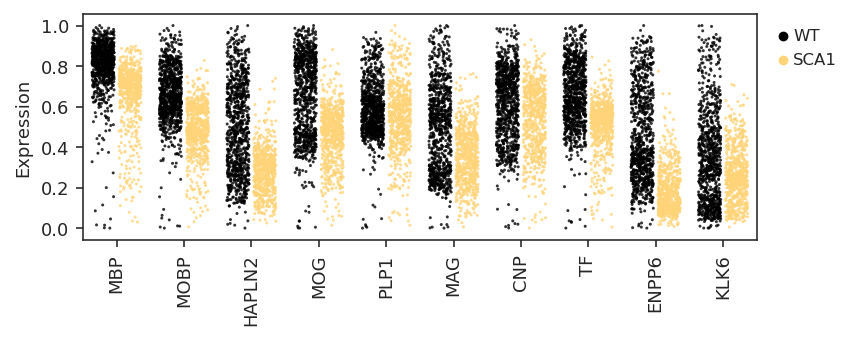

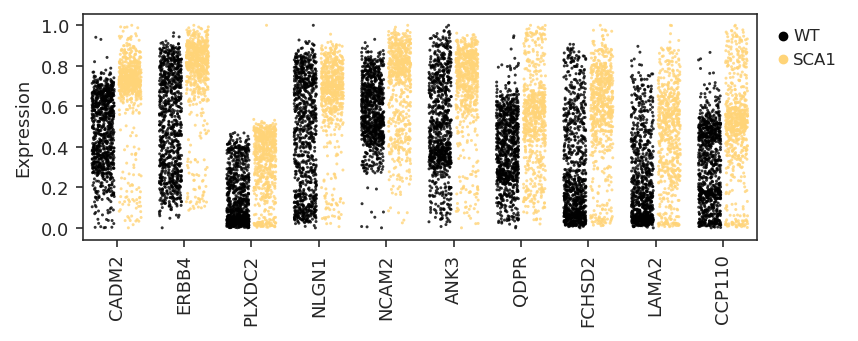

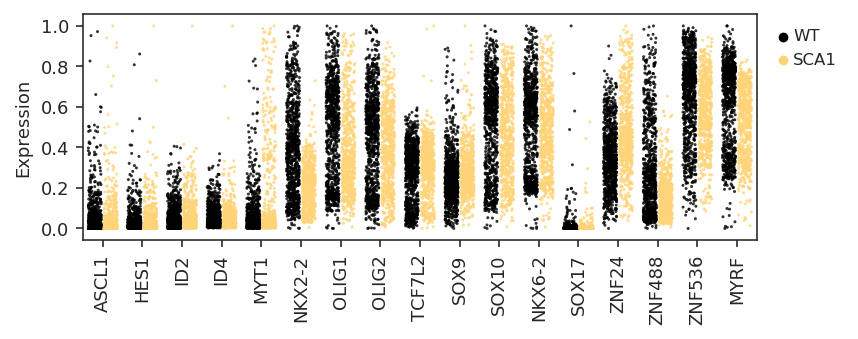

In [45]:
# human
cluster='ctype'
ctype='Oligodendrocyte'

if True : # not encoded yet
    hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]
        
df = pd.DataFrame()
    
## subset data
gene_list = [g for k,v in genes_OL.items() for g in v]
X = AnnData2df(hdata,gene_list,layer='imputed_bbknn',
               id1=cluster,id1_val=ctype,id2=None,
               add_obs='genotype',scaler='range')
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
X['Timepoint'] = [t]*X.shape[0]

## add back data
df = df.append(X, ignore_index=True)
del X

for k in genes_OL.keys():
    df_subset = df.loc[df['Gene'].isin(genes_OL[k]),:]
    
    fig,ax=plt.subplots(1,1,figsize=(6,2))
    p1 = sns.stripplot(x='Gene', y='Expression', hue='genotype', data=df_subset, order=None, hue_order=['WT','SCA1'], jitter=0.33, dodge=True, 
                      orient=None, color=None, palette=cmap_genotype, size=0.5, alpha=0.8, edgecolor='gray', linewidth=0,ax=ax,
                      rasterized=True, s=1.5)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.legend().set_title('')
    ax.legend(bbox_to_anchor=(1.01,1))
    if True :
        # save plot
        fig.savefig(os.path.join(pfp,'jitter_{}.pdf'.format(k)),dpi=300, bbox_inches='tight')

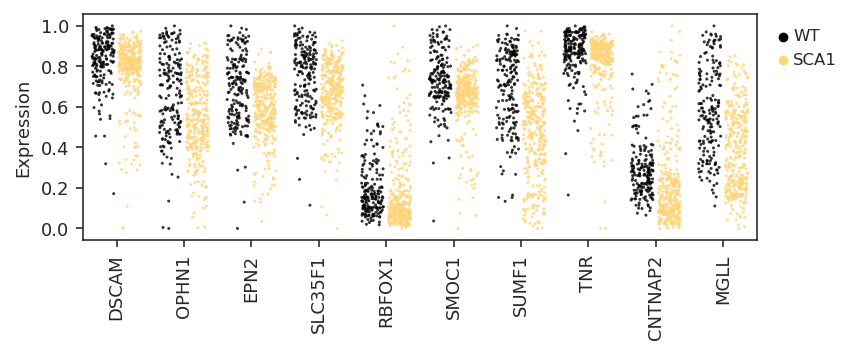

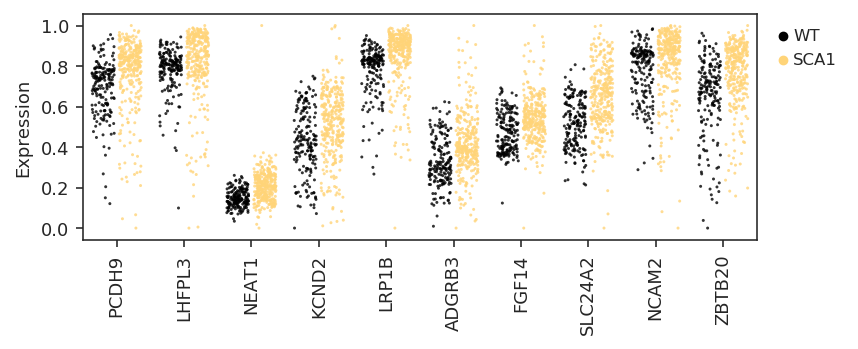

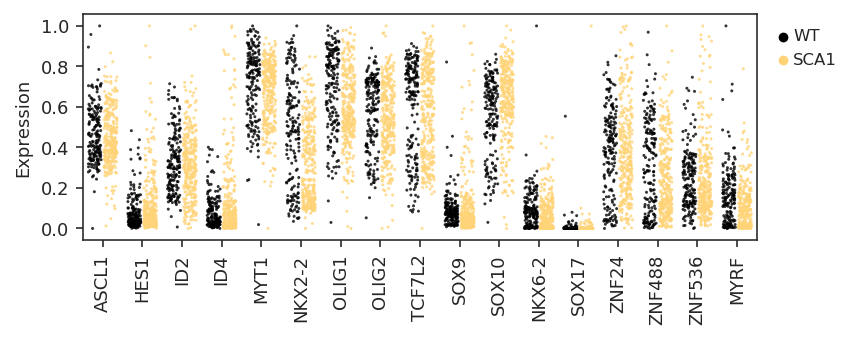

In [47]:
# human
cluster='ctype'
ctype='Oligodendrocyte progenitor cell'

if True : # not encoded yet
    hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]
        
df = pd.DataFrame()
    
## subset data
gene_list = [g for k,v in genes_OPC.items() for g in v]
X = AnnData2df(hdata,gene_list,layer='imputed_bbknn',
               id1=cluster,id1_val=ctype,id2=None,
               add_obs='genotype',scaler='range')
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
X['Timepoint'] = [t]*X.shape[0]

## add back data
df = df.append(X, ignore_index=True)
del X

for k in genes_OPC.keys():
    df_subset = df.loc[df['Gene'].isin(genes_OPC[k]),:]
    
    fig,ax=plt.subplots(1,1,figsize=(6,2))
    p1 = sns.stripplot(x='Gene', y='Expression', hue='genotype', data=df_subset, order=None, hue_order=['WT','SCA1'], jitter=0.33, dodge=True, 
                      orient=None, color=None, palette=cmap_genotype, size=0.5, alpha=0.8, edgecolor='gray', linewidth=0,ax=ax,
                      rasterized=True, s=1.5)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.legend().set_title('')
    ax.legend(bbox_to_anchor=(1.01,1))
    if True :
        # save plot
        fig.savefig(os.path.join(pfp,'jitter_{}.pdf'.format(k)),dpi=300, bbox_inches='tight')

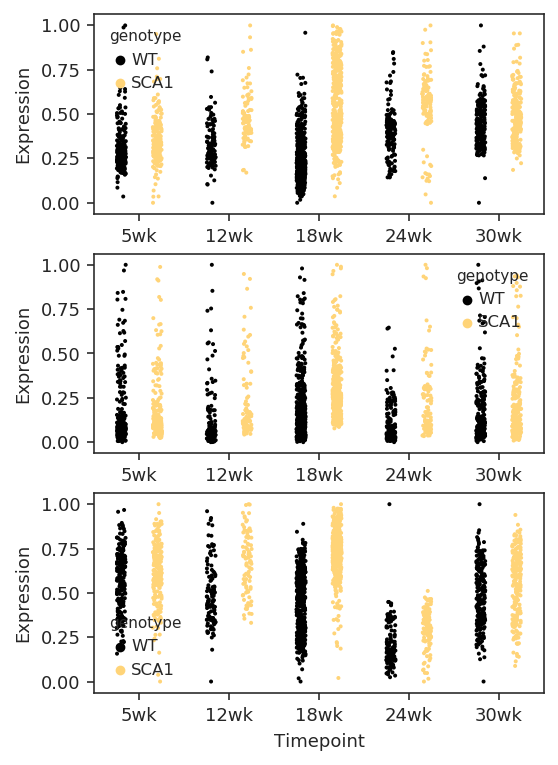

In [168]:
if False :
    ## original jitter plot settings 
    p1 = sns.catplot(x='Timepoint', y='Expression', hue='genotype', 
                     data=df, row='Gene', order=None, hue_order=['WT','SCA1'], 
                     kind='strip', height=1, aspect=4, palette=cmap_genotype, 
                     legend=False, legend_out=True, sharex=True, sharey=True,
                     dodge=True, s=0.8)
    # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    # ax.set_xlabel('')
    # # ax.legend().set_title('')
    # plt.close(2)

# starting to get jitter plots down
fig = plt.figure(figsize=(4,6))
for i,g in enumerate(['Asic2','Nrxn1','Nrxn3']):
    ax = fig.add_subplot(3,1,i+1)
    sns.stripplot(x='Timepoint', y='Expression', hue='genotype', 
                  data=df[df['Gene']==g], order=None, hue_order=['WT','SCA1'], jitter=True, dodge=True, 
                  orient=None, color=None, palette=cmap_genotype, size=2, ax=ax)